In [7]:
import os
import cv2
import copy
import glob
import tkinter
import traceback
import matplotlib
import numpy as np
matplotlib.use('TkAgg')
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib tk

In [110]:
def grab_image_points(fpath, npoints, image=[]):
    # Load in images and correct color scales
    %matplotlib tk
    if len(image) == 0:
        sceneOne = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    else:
        sceneOne = image
    plt.imshow(sceneOne)
    # Collect n points on the image
    points = plt.ginput(npoints, timeout=600)
    # Plot the points
    %matplotlib inline
    for x in range(npoints):
        plt.plot(points[x][0], points[x][1], marker='v', color='cyan')
        plt.text(points[x][0], points[x][1], str(x), bbox=dict(fill=False, edgecolor='red', linewidth=2))
    plt.imshow(sceneOne)
    plt.title('Scene with points selected')
    plt.show()
    return sceneOne, np.array(points)

def create_im_h(p, p_prime):
    # Create a 2x9 array corresponding to linear equations
    return np.array((
       np.array([0, 0, 0, -p[0], -p[1], -1, p[0]*p_prime[1], p[1]*p_prime[1], p_prime[1]]),
       np.array([p[0], p[1], 1, 0, 0, 0, -p[0]*p_prime[0], -p[1]*p_prime[0], -p_prime[0]])
    ))

def create_homography(src_points, dest_points, n_points):
    # For each point correspondence, create the appropriate vector
    # h_temp = []
    # for x in range(n_points):
    #     dat = create_im_h(src_points[x,:], dest_points[x,:])
    #     h_temp.append(dat)
    # # Create the stacked feature vector and solve using the Direct Linear Transformation (DLT) algorithm
    # fullData = np.vstack(h_temp)
    # u,s,vh = np.linalg.svd(fullData)
    # # Find the smallest singular values
    # v = vh.transpose()
    # target_ind = np.argmin(s)
    # h = v[:, -1].reshape(3,3)
    # Set RANSAC parameters
    ransac_reproj_threshold = 0.1
    ransac_max_iter = 5000
    h, mask = cv2.findHomography(src_points, dest_points, cv2.RANSAC, ransac_reproj_threshold, maxIters=ransac_max_iter)
    return h

def find_max_rectangular_mask(image):
    rows = len(image)
    if rows == 0:
        return None

    cols = len(image[0])
    max_area = 0
    max_rect = None
    heights = [0] * (cols + 1)
    stack = []

    for row in range(rows):
        for col in range(cols):
            if image[row][col]:
                heights[col] += 1
            else:
                heights[col] = 0

        stack.clear()
        stack.append(-1)

        for col in range(cols + 1):
            while heights[col] < heights[stack[-1]]:
                h = heights[stack.pop()]
                w = col - stack[-1] - 1
                area = h * w
                if area > max_area:
                    max_area = area
                    max_rect = (row - h + 1, stack[-1] + 1, row, col - 1)

            stack.append(col)

    if max_rect is not None:
        mask = np.zeros_like(image, dtype=bool)
        r1, c1, r2, c2 = max_rect
        mask[r1:r2+1, c1:c2+1] = True
        return mask, (r1,r2+1,c1,c2+1)
    else:
        return None
    
# Now we need to do this for every image in the scene 
# Iterate over each channel and apply the transformation

def apply_homography_to_cube(homography: np.ndarray, rgb_img, hyper_cube):
    # Create the empty data structure - spatial size of rgb image
    # BUT with the same number of channels as the hypercube contains
    data = np.zeros((rgb_img.shape[0], rgb_img.shape[1], hyper_cube.shape[2]), dtype=np.float16)
    # Apply the warp
    for idx in range(hyper_cube.shape[2]):
        data[:,:,idx] = cv2.warpPerspective(
            hyper_cube[:,:,idx],
            homography,
            (rgb_img.shape[1], rgb_img.shape[0]),
            rgb_img,
            borderMode=cv2.BORDER_TRANSPARENT
        )
    return data

def generate_registered_cube(h_ximea_2_img: np.ndarray, h_imec_2_img: np.ndarray, 
                            im_dest: np.ndarray, ximea_cube: np.ndarray, imec_cube: np.ndarray,
                            mask: np.ndarray=[]) -> np.ndarray:
    # Register the image using the precomputed homographies
    ximea_registered = apply_homography_to_cube(h_ximea_2_img, im_dest, ximea_cube)
    imec_registered = apply_homography_to_cube(h_imec_2_img, im_dest, imec_cube)
    # Get image dimensions
    height, width, _ = imec_registered.shape

    # Create a new image with the same dimensions
    imec_shift = np.zeros_like(imec_registered)

    # Shift the image left by one pixel
    # imec_shift[:, 50:, :] = imec_registered[:, :-50, :]
    combined_spectra= np.dstack((ximea_registered,imec_registered))
    return combined_spectra

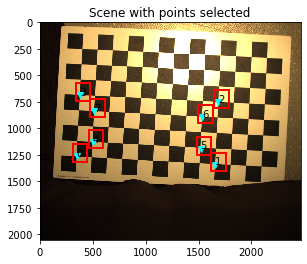

In [103]:
# Read in the RGB images
im_dest, dest_points = grab_image_points('../calibration/plastics_checkerboard_1/rgb/0_rgb.png', 8)

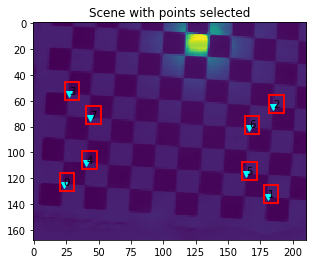

In [105]:
# Read in the IMEC image
imec_img = np.load('../calibration/plastics_checkerboard_1/imec_cal/cal_0_imec.npy')[:,:,0]
cv2.imwrite('../calibration/plastics_checkerboard_1/imec_1.png', imec_img)
im_src, imec_src_points = grab_image_points([], 8, imec_img)

/usr/lib/python3/dist-packages/matplotlib/image.py:397: RuntimeWarning: overflow encountered in scalar subtract
  dv = (np.float64(self.norm.vmax) -
/usr/lib/python3/dist-packages/matplotlib/image.py:401: RuntimeWarning: invalid value encountered in scalar subtract
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:414: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/usr/lib/python3/dist-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in scalar subtract
  resdat /= (vmax - vmin)
/usr/lib/python3/dist-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)


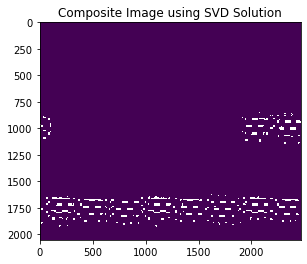

In [108]:
h_imec_2_img = create_homography(imec_src_points, dest_points, 8)
plt.imshow(cv2.warpPerspective(im_src, h_imec_2_img, (im_dest.shape[1],im_dest.shape[0]), im_dest, borderMode=cv2.BORDER_TRANSPARENT))
plt.title('Composite Image using SVD Solution')
plt.show()

In [84]:
np.save('../calibration/imec_to_rgb_homography.npy', h_imec_2_img)

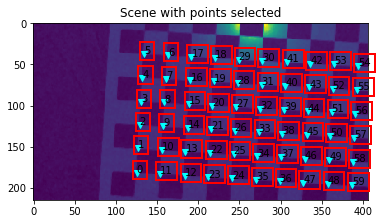

In [69]:
# Read in the XIMEA image
ximea_img = np.load('../calibration/plastics_checkerboard_1/ximea_cal/cal_0_ximea.npy')[:,:,0]
ximea_im_src, ximea_src_points = grab_image_points([], 60, ximea_img)

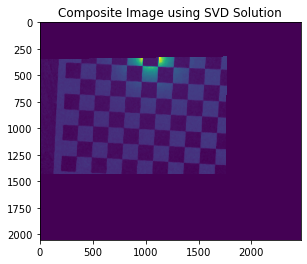

In [80]:
h_ximea_2_img = create_homography(ximea_src_points, dest_points, 8)
plt.imshow(cv2.warpPerspective(ximea_im_src, h_ximea_2_img, (im_dest.shape[1],im_dest.shape[0]), im_dest, borderMode=cv2.BORDER_TRANSPARENT))
plt.title('Composite Image using SVD Solution')
plt.show()

In [81]:
np.save('../calibration/ximea_to_rgb_homography.npy', h_ximea_2_img)

In [72]:
# Create the mask image
ximea_cube = np.load('../calibration/plastics_checkerboard_1/ximea_cal/cal_0_ximea.npy')
imec_cube = np.load('../calibration/plastics_checkerboard_1/imec_cal/cal_0_imec.npy')
h_ximea_2_img = np.load('../calibration/ximea_to_rgb_homography.npy')
h_imec_2_img = np.load('../calibration/imec_to_rgb_homography.npy')
im_dest = cv2.cvtColor(cv2.imread('../calibration/plastics_checkerboard_1/rgb/1_rgb.png'), cv2.COLOR_BGR2RGB)
ximea_mask = apply_homography_to_cube(h_ximea_2_img, im_dest, np.ones(ximea_cube.shape))[:,:,0].astype(bool)
imec_mask = apply_homography_to_cube(h_imec_2_img, im_dest, np.ones(imec_cube.shape))[:,:,0].astype(bool)
mask = np.bitwise_and(ximea_mask, imec_mask)
rect_mask, bounds = find_max_rectangular_mask(mask)
cv2.imwrite('../calibration/mask_rect.png', rect_mask.astype(int))

True

In [73]:
cv2.imread('../calibration/mask_rect.png', cv2.IMREAD_GRAYSCALE).shape

(2054, 2464)

In [6]:
!pwd

/home/nathaniel/ieee_whispers_plastic/processing


In [111]:
# Generate all the registered hyperspectral datacubes
# Load homography for ximea -> rgb
ximea_to_rgb = np.load('../calibration/ximea_to_rgb_homography.npy')
# Load homography for imec -> rgb
imec_to_rgb = np.load('../calibration/imec_to_rgb_homography.npy')
# Image Mask
mask = cv2.imread('../calibration/mask_rect.png', cv2.IMREAD_GRAYSCALE).astype(bool)
pbar = tqdm(glob.glob('../*'))
for folder in pbar:
    if not any([True if z in folder else False for z in ['plastics_teaser']]):
        continue
    pbar.set_description("Processing %s" % folder)
    print(folder)
    if os.path.isfile(folder) or 'dark' in folder or 'white' in folder:
        continue
    # Valid folder, let's make sure calibration directories
    try:
        os.mkdir(os.path.join(folder, 'rgb_registered'))
        os.mkdir(os.path.join(folder, 'hsi_cal_registered'))
    except:
        pass
        # print('Error making folder!')
    # We will need to run through each of the folders
    num = len(os.listdir(os.path.join(folder,'rgb')))
    for idx in tqdm(range(num)):
        # Load rgb
        try:
            rgb = cv2.cvtColor(cv2.imread(os.path.join(folder,'rgb',f'{idx}_rgb.png')), cv2.COLOR_BGR2RGB)
            # Load ximea
            ximea_cube = np.load(os.path.join(folder,'ximea_cal', f'cal_{idx}_ximea.npy'))
            # Load imec
            imec_cube = np.load(os.path.join(folder, 'imec_cal', f'cal_{idx}_imec.npy'))
            # Generate composite datacube
            cube = generate_registered_cube(ximea_to_rgb, imec_to_rgb, rgb, ximea_cube, imec_cube)
            # Mask the cube for saving
            cube_masked = cube[bounds[0]:bounds[1],bounds[2]:bounds[3],:]
            print(rgb.shape)
            rgb_masked = rgb[bounds[0]:bounds[1],bounds[2]:bounds[3],:]
            # Save the masked cube
            # os.remove(os.path.join(folder, 'hsi_cal_registered', f'{idx}_cube.npy'))
            np.savez_compressed(os.path.join(folder, 'hsi_cal_registered', f'{idx}_cube.npz'), cube=cube_masked)
            # Save the masked rgb image
            cv2.imwrite(os.path.join(folder, 'rgb_registered', f'{idx}_rgb.png'), rgb_masked)
        except Exception as e:
            print(traceback.exec())
            print(e)
            continue

  0%|          | 0/20 [00:00<?, ?it/s]

../plastics_teaser


  0%|          | 0/19 [00:00<?, ?it/s]

AttributeError: module 'traceback' has no attribute 'exec'